# Likelihood and model fitting

Fall 2022: Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng(seed=123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}}$$
This is here so we can use `\P` and `\E` and `\var` and `\sd` in LaTeX below.

Outline:

1. Guess at p from flipping coins
2. Infer mu from Gaussian observations
3. General method
4. Relationship to method of moments
5. Example without math

# Guess the probability

i.e., Maximum Likelihood with the Binomial

We've got a weird-looking coin,
and we'd like to figure out the probability that it comes up Heads
when it's flipped.
How do we do this?

*(More generally: from observations of a 0/1-valued random variable $X$ with $\P\{X = 1\} = p$, infer $p$.)*

Let's say out of 20 flips it came up Heads 15 times.
What's your best guess at $p$?

Well, since $X \sim \text{Binomial}(20, p)$,
$$
    \P\{ X = 15 \}
    =
    \binom{20}{15} p^{15} (1-p)^5.
$$
Let's call this $L(p)$.

Maximizing $L(p)$ is the same as maximizing $\log L(p)$, and
$$
\frac{d}{dp} \log L(p) = \frac{15}{p} - \frac{5}{1-p} ,
$$
which is equal to 0 at $p = 3/4$.

Okay, so our guess is $p = 0.75$ "by maximum likelihood".
How sure are we?

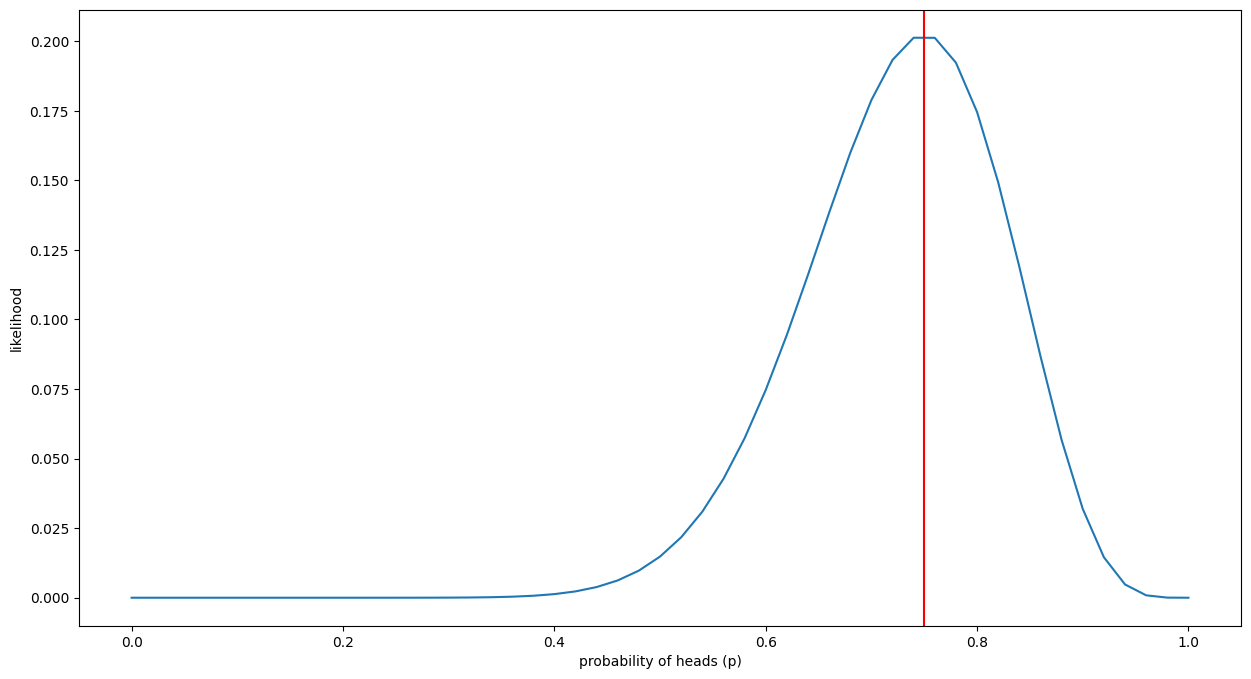

In [2]:
def L(p):
    C = np.math.factorial(20) / (np.math.factorial(15) * np.math.factorial(5))
    return C * (p ** 15) * ((1-p) ** 5)

pvals = np.linspace(0, 1, 51)
plt.plot(pvals, L(pvals))
plt.xlabel("probability of heads (p)")
plt.ylabel("likelihood")
plt.axvline(0.75, c='red');

# Guess the mean

i.e., Maximum Likelihood with the Gaussian

I weighed 5 apples off my tree yesterday; their weights were 112g, 145g, 131g, 98g, and 104g.
I've got about 200 apples on the tree;
what's our estimate of their total weight?

In [3]:
x = [112, 145, 131, 98, 104]
np.mean(x)

118.0

Well, the average weight of those was 118g, so... probably around 200 * 118g = 23600g = 23.6kg?

*More formally:* let's assume the distribution of the weights (across *all* the apples) is Normal.
If the mean is $\mu$ grams and standard deviation $\sigma$ grams, then the chance* of getting an apple
that weighs $x$ grams is
$$
  L(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right) .
$$
$*$ *(okay, this is actually a probability density, but let's go with it)*

So, the chance of getting apples weighing $x_1, \ldots, x_n$ is
$$
  \prod_{i=1}^n L(x_i; \mu, \sigma)
  = 
  \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(- \frac{\sum_{i=1}^n (x_i - \mu)^2}{2 \sigma^2} \right) .
$$

So, the *log-likelihood* is
$$
  \log L(x; \mu, \sigma) = - \frac{1}{2 \sigma^2}\sum_{i=1}^n (x_i - \mu)^2 - \log(2 \pi \sigma^2)/2 ,
$$
and
$$\begin{aligned}
  \frac{d}{d\mu} \log L(x; \mu, \sigma) 
  &=
  - \frac{1}{2\sigma^2}\sum_{i=1}^n 2 (x_i - \mu) \\
  &=
  - \frac{n}{\sigma^2}\left( \left(\frac{1}{n} \sum_{i=1}^n x_i\right) - \mu \right)
\end{aligned}$$
Notice that $\bar x = \sum_{i=1}^n x_i / n$ is the *sample mean*.

So, $L(x;\mu,\sigma)$ is maximized if $\mu = \bar x$.
(But first: check this is a maximum, not a minimum.)
Remarkably, this doesn't depend on $\sigma$!

We've learned that:

1. Given independent samples from a Normal($\mu$, $\sigma$) distribution,
    the maximum-likelihood estimate for $\mu$ is the sample mean.

2. Maximizing the likelihood of a Normal distribution
    requires minimizing the sum of squared errors.

3. The maximum likelihood estimate for the mean apple weight on my tree is 118g.

Again: how certain are we? Now, the answer *depends on $\sigma$*.

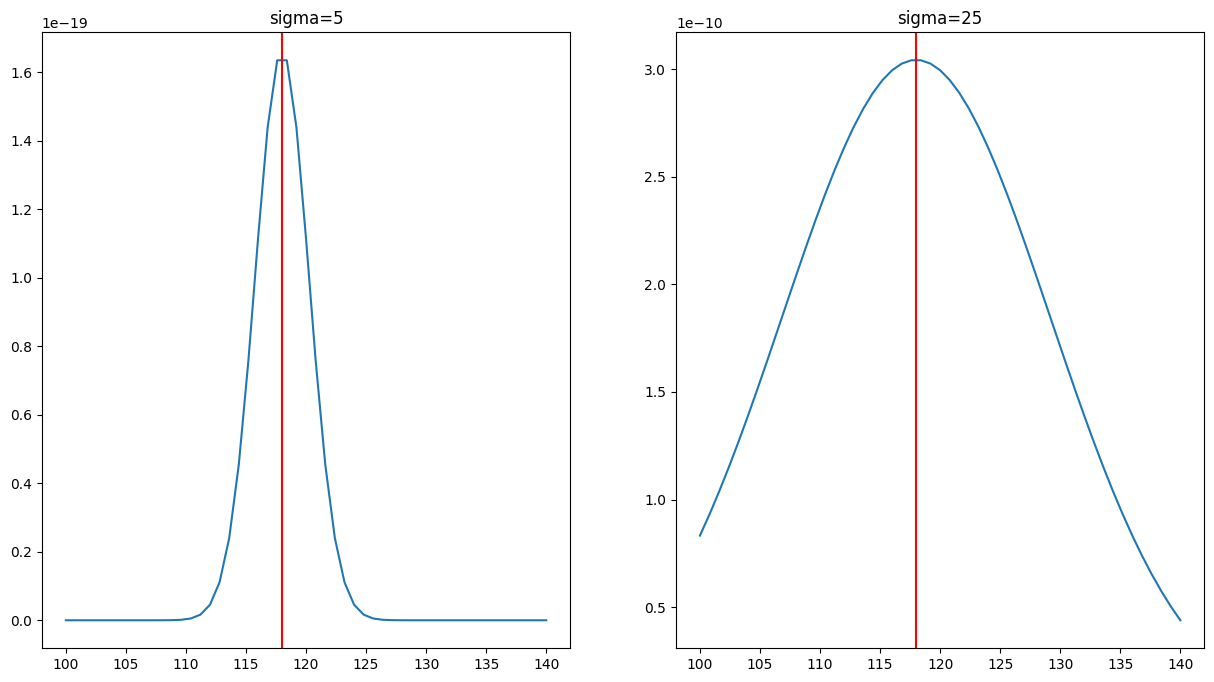

In [4]:
muvals = np.linspace(100, 140, 51)
x = np.array([112, 145, 131, 98, 104])

def normal_L(mu, sigma):
    C = np.sqrt(2 * np.math.pi * sigma**2)
    return np.prod(np.exp(- (x - mu)**2 / (2 * sigma**2)) / C)

sigvals = [5, 25]
fig, axes = plt.subplots(1, len(sigvals))
for sig, ax in zip(sigvals, axes):
    ax.plot(muvals, [normal_L(m, sig) for m in muvals])
    ax.axvline(np.mean(x), c='r')
    ax.set_title(f"sigma={sig}")

**Exercise:** Make the plots using:

In [5]:
from scipy.stats import norm
help(norm.pdf)

Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Probability density function at x of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    pdf : ndarray
        Probability density function evaluated at x



# Likelihood surfaces

So, what did we just do? We

1. formulated a generative model that seems likely to fit the data
    with some free parameters
    that describe what we want to know about,
2. wrote down the *likelihood* (i.e., probability) of generating *our actual data*
    as a function of the parameter(s), and
3. said that "gee, seems like a good guess of the parameter(s) values are the ones that
    make our data look most probable".

*Formally:* given data $D$ and a model $M$ with parameters $\theta \in A$ and likelihood function
$$ L_M(D|\theta) = \P_M\{D|\theta\} , $$
a *maximum likelihood estimate* of $\theta$ is
$$  \theta^* = \text{argmax}_{\theta \in A}\{ L_M(D|\theta) \}, $$
i.e., $\theta^*$ is the parameter values that maximize the likelihood.

# Example: the gamma distribution

Let's say we have hourly rainfall measurements
throughout a winter storm.
We'd like to (a) estimate the average rainfall for the storm
(across a wider region, taking our location as representative),
and (b) fit a distribution to describe the hourly variation.

Let $X_i$ be the number of millimeters of rain
that fell in the $i^\text{th}$ hour.
Since $X_i \ge 0$, let's take
$$
    X_i \sim \text{Gamma}(\text{scale}=\theta, \text{shape}=k) .
$$
Our goal will be to find an $\theta$ and $k$ that describe the data well.
And, here's our data:

In [6]:
# secret data generation; pretend this isn't here
rain = np.round(rng.gamma(scale=25, shape=2, size=72))

In [7]:
rain

array([ 17.,  99.,  79.,  24.,  32.,  45.,  93.,  83., 113.,  32.,   3.,
       114.,  71.,  98.,  56.,  31.,  95.,  31.,  76.,  83.,  70., 107.,
        23.,  40., 168.,  43.,  43.,  28.,  20.,  49.,  26.,  32.,  10.,
        58.,  52.,  35.,  81., 124.,  28.,  46.,  25., 120.,  24.,  17.,
        57.,  96.,  59., 100.,  33.,  74.,  27.,  33.,  33.,  35.,  76.,
       104.,  31.,  24.,  33.,  24.,  73.,  34.,  50.,  53.,  50.,  33.,
       106., 125.,  44.,  94.,  35.,  54.])

## Maximum likelihood

We *could* look up the likelihood function for the
[Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
and then try to solve it for the maximum.
But we're just trying to optimize over two parameters, so it's easy to do by computer:

In [8]:
from scipy.stats import gamma

def logL(theta, k):
    lpdfs = gamma.logpdf(rain, a=k, scale=theta) # "a" is the shape parameter here
    return np.sum(lpdfs)

from scipy.optimize import minimize
max_L = minimize(lambda x: -logL(*x), x0=(24, 1.8))
mle_theta, mle_k = max_L['x']
max_L

      fun: 348.1884538503342
 hess_inv: array([[14.27925121, -1.48033603],
       [-1.48033603,  0.18579412]])
      jac: array([0.00000000e+00, 7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([21.17999438,  2.71089168])

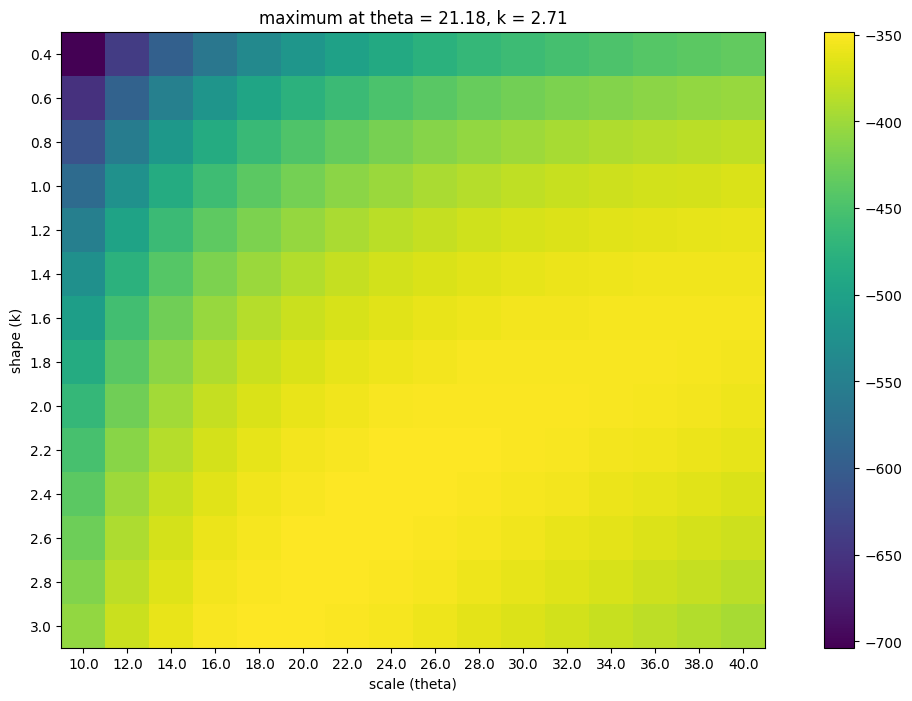

In [9]:
thetavals = pretty([10, 40], 20)
kvals = np.round(pretty([0.5, 3], 10), 2)
Lmap = np.array(
    [[logL(theta, k) for theta in thetavals] for k in kvals]
)

fig, ax = plt.subplots()
im = ax.imshow(Lmap)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("scale (theta)"); ax.set_ylabel("shape (k)")
ax.set_xticks(np.arange(len(thetavals)), labels=thetavals)
ax.set_yticks(np.arange(len(kvals)), labels=kvals)
ax.set_title(f"maximum at theta = {mle_theta:.2f}, k = {mle_k:.2f}");

**Comparison:** The method of moments estimator for this data is

In [10]:
obs_mean = np.mean(rain)
obs_sd = np.std(rain)
theta = obs_sd**2  / obs_mean - 1
k = obs_mean / theta
print(f"MOM estimates: theta = {theta:.2f}, k = {k:.2f}.")
print(f"MLE estimates: theta = {max_L['x'][0]:.2f}, k = {max_L['x'][1]:.2f}.")

MOM estimates: theta = 19.25, k = 2.98.
MLE estimates: theta = 21.18, k = 2.71.


*What about our question?* Well,

In [11]:
print(f"The observed mean rainfall/hour is {obs_mean:.3f} mm and the MLE-predicted mean is {(mle_theta * mle_k):.3f} mm.")

The observed mean rainfall/hour is 57.417 mm and the MLE-predicted mean is 57.417 mm.


This gives a good guess. But: *how sure are we*?
*Next:* one way of approaching this question - $p$-values.